In [23]:
! python3 -m pip install --upgrade pip
! python3 -m pip install  --upgrade SpeechRecognition
! python3 -m pip install  --upgrade pydub
! python3 -m pip install  --upgrade sklearn
! python3 -m pip install --upgrade textstat

In [24]:
import IPython.display as ipd
import librosa
import librosa.display
import kapre
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
import textstat
import time
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [25]:
import warnings
warnings.filterwarnings('ignore')

# Transcribe audio data to txt data

In [26]:
# TODO make an input from user
data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train'

audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

lang_ = 'en-US'

r = sr.Recognizer()

In [27]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

meta['ID'] = meta['ID'].str.strip()

meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,NA,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [28]:
sum(meta.MMSE == ' NA')

1

In [29]:
# Replace all NAs
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

# TODO - see if this works - Replace all scores in cc group to 30
meta.loc[meta['Group'] == 'cc', 'MMSE'] = 30
meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,30,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,30,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [30]:
meta.dtypes

index      int64
ID        object
Age        int64
Gender    object
MMSE       int64
Group     object
dtype: object

In [31]:
def startConversion(path, filename, lang = lang_):
                
    # Create output file name
    output_dir = path + 'output_text/'
    output_file = '.'.join(filename.split(sep='.')[:-1]) + '.txt'
    output_file_path = output_dir + output_file
    
    # If output file does not exist, continue
    if os.path.exists(output_file_path):
        print("Sorry, " + output_file_path + " already exists")
    else:
        full_path = path + filename

        with sr.AudioFile(full_path) as source:
            print('Transcribing file: ' + str(filename) + ' in path: ' + str(full_path))
            audio_text = r.listen(source)
            # recognize_() method will throw a request error if the API is unreachable, hence using exception handling
            try:

                # using google speech recognition
                # print('Converting audio transcripts into text ...')
                text = r.recognize_google(audio_text)

                # Create output directory
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                with open(output_file_path, 'w') as f:
                    f.write(text)
                print('Finished transcribing text file ' + str(output_file) + ' at location ' + output_file_path)

            except Exception as e:
                print('Error: ' + str(e) + ' <- this guy')

In [32]:
# Running for CC path
onlyfiles = [f for f in listdir(audio_path_cc) if isfile(join(audio_path_cc, f))]

# Creating this for reference later
audio_cc_text_path = audio_path_cc + 'output_text/'

for filename in onlyfiles:
    startConversion(path = audio_path_cc, filename = filename)

Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S001.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S002.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S003.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S004.txt already exists
Transcribing file: S005.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S005.wav
Error:  <- this guy
Transcribing file: S006.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S006.wav
Error:  <- this guy
Transcribing file: S007.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S007.wav

In [33]:
# Running for CD path
onlyfiles = [f for f in listdir(audio_path_cd) if isfile(join(audio_path_cd, f))]

# Creating this for reference later
audio_cd_text_path = audio_path_cd + 'output_text/'

for filename in onlyfiles:
    startConversion(path = audio_path_cd, filename = filename)

Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S079.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S080.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S081.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S082.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S083.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S084.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S086.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/A

In [34]:
text_dict = {"ID": [], "Text": []}

# CC path
onlytextfiles_cc = [f for f in listdir(audio_cc_text_path) if isfile(join(audio_cc_text_path, f))]
        
for filename in onlytextfiles_cc:
    just_name = filename.split(sep='.')[:-1][0]
    # print("Adding to dictionary: " + str(just_name))
    full_text_file_path = audio_cc_text_path + filename

    # Make all text lowercase
    # Remove special characters
    with open(full_text_file_path, "r") as file:
        data = file.read().replace('\n', '')
        text_dict["ID"].append(just_name)
        text_dict["Text"].append(data)

# CD path
onlytextfiles_cd = [f for f in listdir(audio_cd_text_path) if isfile(join(audio_cd_text_path, f))]

for filename in onlytextfiles_cd:
    just_name = filename.split(sep='.')[:-1][0]
    # print("Adding to dictionary: " + just_name)
    full_text_file_path = audio_cd_text_path + filename

    # Make all text lowercase
    # Remove special characters
    with open(full_text_file_path, "r") as file:
        data = file.read().replace('\n', '')
        text_dict["ID"].append(just_name)
        text_dict["Text"].append(data)

print("Done!")

Done!


In [35]:
# Convert the dictionary into DataFrame 
text_df = pd.DataFrame(text_dict)
text_df

,ID,Text
0,S001,tell me everything that you see going on in th...
1,S002,picture
2,S003,okay there is a little boy and he's getting he...
3,S004,Homedics laugh you ready well the sink is over...
4,S009,boy is taking cookies from the cookie jar givi...
...,...,...
97,S151,everything that you see happening in that pict...
98,S153,and tell me everything that you see happening ...
99,S154,okay and the boys getting in the cookie jar is...
100,S156,can you tell me now this one is in the cookie ...


In [36]:
merged_data = pd.merge(meta, text_df, on = "ID", how = "inner")
merged_data

,index,ID,Age,Gender,MMSE,Group,Text
0,0,S001,74,male,30,cc,tell me everything that you see going on in th...
1,1,S002,62,female,30,cc,picture
2,2,S003,69,female,30,cc,okay there is a little boy and he's getting he...
3,3,S004,71,female,30,cc,Homedics laugh you ready well the sink is over...
4,7,S009,67,male,30,cc,boy is taking cookies from the cookie jar givi...
...,...,...,...,...,...,...,...
96,49,S150,58,male,20,cd,now the boy on the chair is falling reaching u...
97,50,S151,72,male,24,cd,everything that you see happening in that pict...
98,51,S153,68,female,12,cd,and tell me everything that you see happening ...
99,52,S154,65,female,20,cd,okay and the boys getting in the cookie jar is...


### Making some relevant columns categorical

In [37]:
# Make dummy categorical values and remove redundant first column
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Group'], drop_first=True)
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd
0,0,S001,74,30,tell me everything that you see going on in th...,1,0
1,1,S002,62,30,picture,0,0
2,2,S003,69,30,okay there is a little boy and he's getting he...,0,0
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0
...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1
97,50,S151,72,24,everything that you see happening in that pict...,1,1
98,51,S153,68,12,and tell me everything that you see happening ...,0,1
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1


# Reduce output labels by bucketizing

Reference: https://pubmed.ncbi.nlm.nih.gov/16473978/
MMSE ranges:
* 30 for no
* 26-29 for questionable
* 21-25 for mild
* 11-20 for moderate
* 0-10 for severe dementia

In [38]:
# Set a default value
merged_data['dementia_stage_num'] = 0
merged_data['dementia_stage_text'] = 'None'

In [39]:
# Set dementia stage value for all row indexes which MMSE are in certain ranges

# Mild stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 1
merged_data['dementia_stage_text'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 'Mild'

# Moderate/Severe stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] < 21)] = 2
merged_data['dementia_stage_text'][(merged_data['MMSE'] < 21)] = 'Moderate/Severe'

merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None
1,1,S002,62,30,picture,0,0,0,None
2,2,S003,69,30,okay there is a little boy and he's getting he...,0,0,0,None
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0,0,None
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0,0,None
...,...,...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1,2,Moderate/Severe
97,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild
98,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe


In [40]:
# See number of each type
print(merged_data['dementia_stage_num'].value_counts())

0    51
2    39
1    11
Name: dementia_stage_num, dtype: int64


### Adding readability consensus score as a feature

In [41]:
start = time.time()
# add an empty column 
merged_data['readability_score_consensus'] = '' 

# Returns estimated grade level for readability - e.g. '9' means appropriate for the 9th grade
for i in merged_data.index:
    merged_data.loc[i, 'readability_score_consensus'] = textstat.text_standard(merged_data.loc[i, 'Text'], float_output=True)

end = time.time()
    
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text,readability_score_consensus
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None,28
1,1,S002,62,30,picture,0,0,0,None,0
2,2,S003,69,30,okay there is a little boy and he's getting he...,0,0,0,None,0
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0,0,None,9
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0,0,None,14
...,...,...,...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1,2,Moderate/Severe,8
97,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild,20
98,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe,10
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe,21


In [42]:
print("This took: " + str(end-start) + " seconds")

This took: 0.08958578109741211 seconds


## Vectorize test data

In [43]:
# Vectorize text data so model can take it in
# TODO make it so english is not hardcoded, flexible for all languages
# https://www.justintodata.com/logistic-regression-example-in-python/
# https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(merged_data['Text'])
vectorizedTextDF = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names())
print(vectorizedTextDF)

      10  104  303   40    about  acting  action  active  ahead       all  \
0    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
1    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
2    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.081485   
3    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
4    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.171352   
..   ...  ...  ...  ...      ...     ...     ...     ...    ...       ...   
96   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
97   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
98   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
99   0.0  0.0  0.0  0.0  0.17899     0.0     0.0     0.0    0.0  0.000000   
100  0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   

     ...      with  woman   working  yard  year  yet       you  young  \
0 

### Get model columns only

In [44]:
merged_data_useful_cols = merged_data[["Age", "Gender_ male ", "readability_score_consensus"]]
X_data = pd.concat([merged_data_useful_cols, vectorizedTextDF], axis=1)

# TODO, make binary classifier first? e.g. has or does not have
y_data = merged_data[["dementia_stage_num"]]

In [45]:
X_data

,Age,Gender_ male,readability_score_consensus,10,104,303,40,about,acting,action,...,with,woman,working,yard,year,yet,you,young,youngster,your
0,74,1,28,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.208362,0.0,0.000000,0.0,0.0,0.0,0.164697,0.0,0.0,0.000000
1,62,0,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,69,0,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.274953,0.0,0.000000,0.0,0.0,0.0,0.048296,0.0,0.0,0.000000
3,71,0,9,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.100045,0.0,0.0,0.000000
4,67,1,14,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,58,1,8,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.220035
97,72,1,20,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.239497,0.0,0.0,0.0,0.241061,0.0,0.0,0.000000
98,68,0,10,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.159917,0.0,0.0,0.000000
99,65,0,21,0.0,0.0,0.0,0.0,0.17899,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [46]:
y_data

,dementia_stage_num
0,0
1,0
2,0
3,0
4,0
...,...
96,2
97,1
98,2
99,2


# Split dataset

In [47]:
# dividing X, y into train and test data 
# 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
print("Training data set is length: " +str(len(y_train)))
print("Test data set is length: " +str(len(y_test)))

Training data set is length: 80
Test data set is length: 21


# Train and predict on Logistic regression

In [49]:
start = time.time()

param_values = {
                'penalty' : ['l1', 'l2'],
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'max_iter' : [10000]
           }

# Try out the different n_estimators parameters
lr_model = GridSearchCV(estimator = LogisticRegression(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

lr_model.fit(X_train, y_train)

best_lr_C_value = lr_model.best_params_['C']
best_penalty_value = lr_model.best_params_['penalty']

print("Best C: " + str(best_lr_C_value) + ", best penalty: " + str(best_penalty_value))
lr_pred = lr_model.predict(X_test)
end=time.time()
print(classification_report(lr_pred, y_test))

Best C: 5, best penalty: l2
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.00      0.00      0.00         0
           2       0.88      0.78      0.82         9

    accuracy                           0.81        21
   macro avg       0.59      0.54      0.56        21
weighted avg       0.89      0.81      0.85        21



In [50]:
print("This took: " + str(end-start) + " seconds")

This took: 28.72352910041809 seconds


In [51]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))

Accuracy:  0.8095238095238095


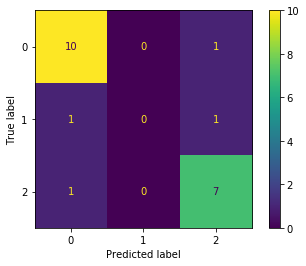

In [52]:
# Create and show confusion matrix
plot_confusion_matrix(lr_model, X_test, y_test)
plt.show()  

# SVM multi class classification based on stage

In [129]:
# Should be same data
# 'OVO' gets better results for some reason
# Linear kernel gets better results for some reason
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
start=time.time()

param_values = {
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                'decision_function_shape' : ['ovo']
           }

# Try out the different n_estimators parameters
svm_model = GridSearchCV(estimator = SVC(), param_grid = param_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

best_svm_C_value = svm_model.best_params_['C']
best_kernel_value = svm_model.best_params_['kernel']

print("Best C: " + str(best_svm_C_value) + ", best kernel: " + str(best_kernel_value))

end=time.time()

print(classification_report(svm_pred, y_test))

Best C: 500, best kernel: poly
              precision    recall  f1-score   support

           0       1.00      0.58      0.73        19
           1       0.00      0.00      0.00         0
           2       0.25      1.00      0.40         2

    accuracy                           0.62        21
   macro avg       0.42      0.53      0.38        21
weighted avg       0.93      0.62      0.70        21



In [55]:
print("This took: " + str(end-start) + " seconds")

This took: 3.503702402114868 seconds


In [56]:
print("Accuracy: ", accuracy_score(y_test, svm_pred))

Accuracy:  0.6190476190476191


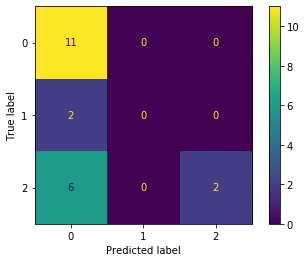

In [57]:
# Create and show confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()  

# Random forest classifier

In [135]:
# creating a RF classifier 
random_forest = RandomForestClassifier()   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
random_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
start=time.time()

n_estimators_values = {'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

# Try out the different n_estimators parameters
rf_model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = n_estimators_values, cv = None, scoring = 'accuracy', n_jobs=-1) 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)

best_n_estimators = rf_model.best_params_['n_estimators']
print("best n_estimators: " + str(best_n_estimators))

end=time.time()

print(classification_report(rf_pred, y_test))

best n_estimators: 900
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.00      0.00      0.00         0
           2       0.62      0.71      0.67         7

    accuracy                           0.71        21
   macro avg       0.51      0.48      0.49        21
weighted avg       0.81      0.71      0.76        21



In [60]:
print("This took: " + str(end-start) + " seconds")

This took: 20.967854976654053 seconds


In [61]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, rf_pred)) 

ACCURACY OF THE MODEL:  0.7142857142857143


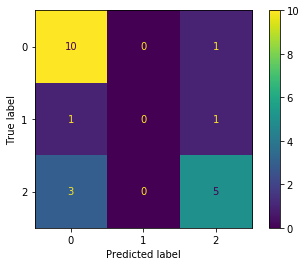

In [62]:
# Create and show confusion matrix
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()  

# Neural net

In [ ]:
start=time.time()

# Set up N-fold cross validation to find best parameters
parameters = {    
    'hidden_layer_sizes': [
        (1,), (2,), (5,), (10,), (20,), (50,), (100,),
        (1,1), (2,2), (5,5), (10,10), (20,20), (50,50), (100,100),
        (1,1,1), (2,2,2), (5,5,5), (10,10,10), (20,20,20), (50,50,50), (100,100,100)
    ], 
    'activation': ["logistic", "relu", "tanh"],
    'solver': ['lbfgs'], 
    'alpha': 10.0 ** -np.arange(1, 10), 
    'max_iter': [200, 500, 1000], 
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7,1e-8],
    'verbose' : [True] # to print out messages for debugging later
}

# n_jobs -1 maximizes jobs in background
clf = GridSearchCV(MLPClassifier(), parameters, cv = None, scoring = 'accuracy', n_jobs=-1)

# Create train and test the model
clf.fit(X_train, y_train)
# best_score = clf.score(X_test, y_test)
    
# Print the classification report for the NN model
mlp_pred = clf.predict(X_test)

print("Best parameters are: ")
print(clf.best_params_)
print("Classification report starts here: ")
print(classification_report(mlp_pred, y_test))
end=time.time()



Original exception was:

Error in sys.excepthook:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 169, in excepthook
KeyboardInterrupt

Original exception was:
Traceback (most recent call last):
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
KeyboardInterrupt
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 614, in _exitfunc
    pending = cls._select_for_exit()
  File "/usr/lib/python3.6/weakref.py", line 595, in _select_for_exit
    L = [(f,i) for (f,i) in cls._registry.items() i

In [ ]:
print("This took: " + str(end-start) + " seconds")

In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, mlp_pred))

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()  